In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 833.9 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.initializers import RandomUniform
from sklearn.model_selection import KFold
import keras_tuner as kt
from keras.initializers import GlorotNormal
from keras.optimizers import Adam
from keras.layers import  Dropout

In [ ]:
df=pd.read_csv("fraud2.csv")

In [ ]:
# Arreglo variables para ser introducidas al modelo

from statsmodels.api import OLS
from statsmodels.api import Logit
from sklearn import metrics
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

df = df.dropna()

# Eliminar las columnas
columnas_a_eliminar = ['trans_date_trans_time','first','last','street','city','zip','lat','long','trans_num','merch_lat','merch_long']
df = df.drop(columnas_a_eliminar, axis = 1)

# Inicializar el codificador de etiquetas
label_encoder = LabelEncoder()

# Codificar la variable categórica
df['merchant'] = label_encoder.fit_transform(df['merchant'])
df['category'] = label_encoder.fit_transform(df['category'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['state'] = label_encoder.fit_transform(df['state'])
df['job'] = label_encoder.fit_transform(df['job'])

# Convertir la columna 'city_pop' a tipo numérico
columnas_numericas = ['city_pop']
df[columnas_numericas] = df[columnas_numericas].astype(float)

# Convertir la columna 'unix_time' de formato Unix a tipo float
df['unix_time'] = df['unix_time'].astype(float)

# Convertir la columna 'dob' a formato de fecha
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')

# Obtener la fecha actual
now = datetime.now()

# Calcular la edad
df['age'] = now.year - df['dob'].dt.year - np.where((now.month < df['dob'].dt.month) | ((now.month == df['dob'].dt.month) & (now.day < df['dob'].dt.day)), 1, 0)
df.insert(loc = 10, column = 'age', value = df.pop('age'))

df = df.drop('dob', axis=1)

# Convertir la columna 'is_fraud' a tipo numérico
df['is_fraud'] = df['is_fraud'].astype(int)

# Convertir X a un tipo numérico adecuado
X = df.drop(["is_fraud"], axis = 1)
y = df['is_fraud']

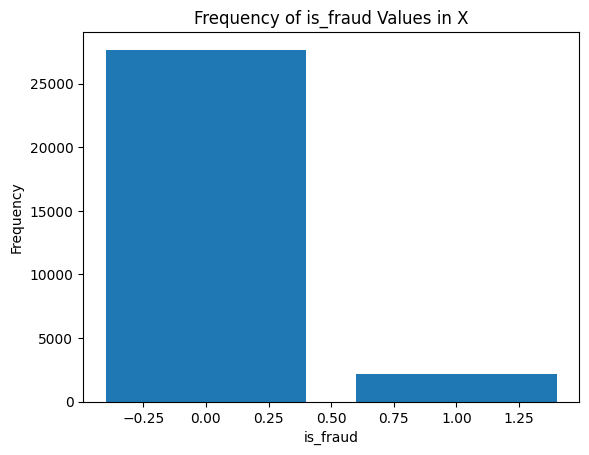

In [ ]:
# prompt: generame un grafico de frecuencia para el datafram x para is:fraud

import matplotlib.pyplot as plt

# Obtener los valores únicos de la columna "is_fraud"
fraud_values = y.unique()

# Crear un diccionario para almacenar las frecuencias
fraud_counts = {}

# Contar la frecuencia de cada valor de "is_fraud"
for value in fraud_values:
    fraud_counts[value] = df["is_fraud"].value_counts()[value]

# Crear el gráfico de frecuencias
plt.bar(fraud_values, fraud_counts.values())
plt.xlabel("is_fraud")
plt.ylabel("Frequency")
plt.title("Frequency of is_fraud Values in X")
plt.show()


In [ ]:
from collections import Counter

In [ ]:
cont_fraud = df['is_fraud'].value_counts()
nms = cont_fraud[0]
val = cont_fraud[1]

print(nms,val)

27678 2145


In [ ]:
#Aíslo cada conjunto de datos por categoría
df_nofraud = df[df['is_fraud'] == 0]
df_fraud = df[df['is_fraud'] == 1]

# Cantidad de observaciones
n_nofraud = df_nofraud.shape[0]
n_fraud = df_fraud.shape[0]

#Se sobre muestrean los casos de fraude
over_fraud = df_fraud.sample(n = n_nofraud, replace = True, random_state = 123)
#Se sub muestrean los casos de no fraude
under_nofraud = df_nofraud.sample(n = n_fraud, replace = False, random_state = 123)

In [ ]:
# Concatenamos sobre muestreo con el conjunto de datos de no fraude
ovesamp_df = pd.concat([df_nofraud,over_fraud])

In [ ]:
# Concatenamos sobre muestreo con el conjunto de datos de no fraude
ovesamp_df = pd.concat([df_nofraud,over_fraud])

# Concatenamos sub muestreo con el conjunto de datos de fraude
subsamp_df = pd.concat([df_fraud,under_nofraud])

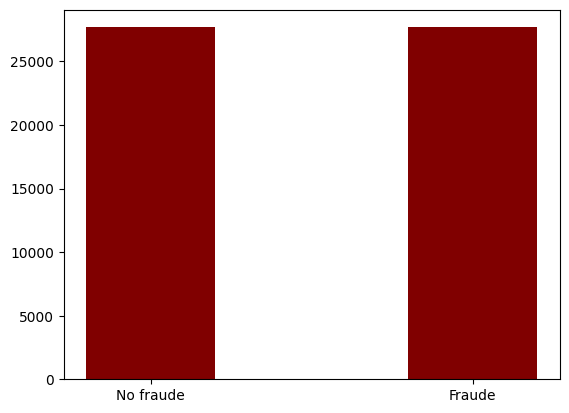

In [ ]:
# Verificamos pariedad de clases para el sobre muestreo
aux_over = dict(Counter(ovesamp_df['is_fraud']))

nms = aux_over.keys()
val = aux_over.values()

nms = ['No fraude','Fraude']

plt.bar(nms, val, color = 'maroon',width = 0.4)
plt.show()

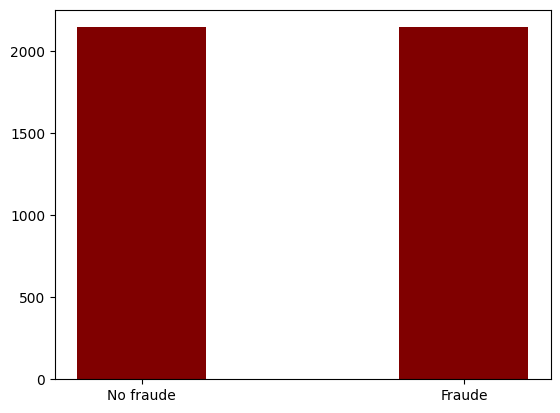

In [ ]:
# Verificamos pariedad de clases para el sub muestreo

aux_under = dict(Counter(subsamp_df['is_fraud']))

nms = aux_under.keys()
val = aux_under.values()

nms=['No fraude','Fraude']

plt.bar(nms, val, color = 'maroon',width = 0.4)
plt.show()

In [ ]:
# Red Neuronal Datos Over

In [ ]:
Xover = ovesamp_df.drop(["is_fraud"], axis = 1)
yover = ovesamp_df['is_fraud']

In [ ]:
Xsub = subsamp_df.drop(["is_fraud"], axis = 1)
ysub = subsamp_df['is_fraud']

In [ ]:
ovesamp_df=ovesamp_df.to_numpy()

scaler = MinMaxScaler()
model_sc=scaler.fit(ovesamp_df)
ovesamp_df=model_sc.transform(ovesamp_df)

In [ ]:
nrowtotover = ovesamp_df.shape[0]
ncoltotover = ovesamp_df.shape[1]

ncolxover = Xover.shape[1]

In [ ]:
idxover=list(range(0,nrowtotover))

np.random.seed(seed=2344)
np.random.shuffle(idxover)

ovesamp_df=ovesamp_df[idxover,]

In [ ]:
subsamp_df=subsamp_df.to_numpy()

scaler = MinMaxScaler()
model_sc=scaler.fit(subsamp_df)
subsamp_df=model_sc.transform(subsamp_df)

In [ ]:
nrowtotsub = subsamp_df.shape[0]
ncoltotsub = subsamp_df.shape[1]

ncolxsub = Xsub.shape[1]

In [ ]:
idxsub=list(range(0,nrowtotsub))

np.random.seed(seed=2344)
np.random.shuffle(idxsub)

subsamp_df=subsamp_df[idxsub,]

In [ ]:
# Red Neuronal Datos Totales


df=df.to_numpy()

scaler = MinMaxScaler()
model_sc=scaler.fit(df)
df=model_sc.transform(df)

In [ ]:
nrowtot = df.shape[0]
ncoltot = df.shape[1]

ncolx = X.shape[1]

In [ ]:
idx=list(range(0,nrowtot))

np.random.seed(seed=2344)
np.random.shuffle(idx)

df=df[idx,]

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def build_model(hp):
    seed_value=3
    tf.random.set_seed(seed_value)
    hp_learning_rate = hp.Choice('learning_rate', values = [0.001, 0.01, 0.1])
    #activation = hp.Choice('activation',values = ['relu','sigmoid','tanh','softmax'])
    initializer = GlorotNormal(seed=seed_value)
    optimizer1 = Adam(lr=hp_learning_rate)

    model = Sequential()
    model.add(Dense(units=hp.Int('layers_units_x', 50, 350, step=10), input_dim = ncolx,  kernel_initializer=initializer, activation='tanh'))

    for i in range(hp.Int('layers_', 1, 6)):
        model.add(Dropout(rate=hp.Choice('dp_rate_'+ str(i), values = [0.25, 0.5, 0.75])))
        model.add(Dense(units=hp.Int('units_' + str(i), 50, 350, step=10),activation='tanh',kernel_initializer=initializer))

    model.add(Dense(1, activation='softmax',kernel_initializer=initializer))

    model.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def summary_class(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1, 2)

def summary_train_val_test(y_train_obs, y_train_pred, y_val_obs, y_val_pred, y_test_obs, y_test_pred):
    train = summary_class(y_train_obs, y_train_pred)
    val = summary_class(y_val_obs, y_val_pred)
    test = summary_class(y_test_obs, y_test_pred)
    df = pd.DataFrame([train, val, test], index=["Train", "Val", "Test"], columns=["Accuracy", "Precision", "Recall", "F1"])
    return df

In [ ]:
from sklearn.metrics import  roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print('\nAUC score:',round(roc_auc_score(true_y, y_prob),2) )

# Función que mostrara el resumen para el entrenamiento y prueba
def summary_CM(actual, predicted):
    Accuracy = metrics.accuracy_score(actual, predicted)
    Precision = metrics.precision_score(actual, predicted)
    Sensitivity_recall = metrics.recall_score(actual, predicted)
    Specificity = metrics.recall_score(actual, predicted, pos_label=0)
    F1_score = metrics.f1_score(actual, predicted)
    print("\nAccuracy:",round(Accuracy,2),
          "\nPrecision:",round(Precision,2),
          "\nSensitivity_recall:",round(Sensitivity_recall,2),
          "\nSpecificity:",round(Specificity,2),
          "\nF1_score:",round(F1_score,2))

In [ ]:
tuner = kt.RandomSearch(build_model,
                     objective = 'val_loss',
                     max_trials=10,
                     directory = '/content/Randomsearch',
                     project_name='Randomsearch_7')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

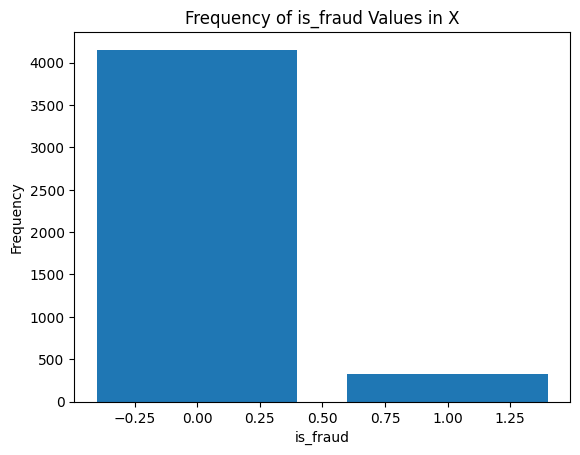

In [ ]:
# prompt: generame un grafico de frecuencia para el datafram x para is:fraud

import matplotlib.pyplot as plt

# Obtener los valores únicos de la columna "is_fraud"
fraud_values = y_test.unique()

# Crear un diccionario para almacenar las frecuencias
fraud_counts = {}

# Contar la frecuencia de cada valor de "is_fraud"
for value in fraud_values:
    fraud_counts[value] = y_test.value_counts()[value]

# Crear el gráfico de frecuencias
plt.bar(fraud_values, fraud_counts.values())
plt.xlabel("is_fraud")
plt.ylabel("Frequency")
plt.title("Frequency of is_fraud Values in X")
plt.show()


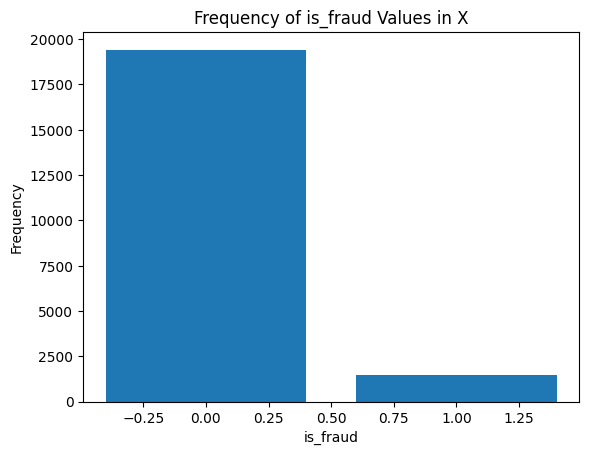

In [ ]:
# prompt: generame un grafico de frecuencia para el datafram x para is:fraud

import matplotlib.pyplot as plt

# Obtener los valores únicos de la columna "is_fraud"
fraud_values = y_train.unique()

# Crear un diccionario para almacenar las frecuencias
fraud_counts = {}

# Contar la frecuencia de cada valor de "is_fraud"
for value in fraud_values:
    fraud_counts[value] = y_train.value_counts()[value]

# Crear el gráfico de frecuencias
plt.bar(fraud_values, fraud_counts.values())
plt.xlabel("is_fraud")
plt.ylabel("Frequency")
plt.title("Frequency of is_fraud Values in X")
plt.show()


In [ ]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
nrowx = X_train.shape[0]

In [ ]:
tuner.search(X_train, y_train, epochs=30,batch_size=nrowx,verbose=0,validation_data=(X_val, y_val))

In [ ]:
best_model1=tuner.get_best_models(num_models=1)[0]
best_model2=tuner.get_best_models(num_models=2)[1]
best_model3=tuner.get_best_models(num_models=3)[2]

In [ ]:
best_hps1 = tuner.get_best_hyperparameters(num_trials = 5)[0].values
best_hps2 = tuner.get_best_hyperparameters(num_trials = 5)[1].values
best_hps3 = tuner.get_best_hyperparameters(num_trials = 5)[2].values

In [ ]:
lrt1=best_hps1['learning_rate']
lrt2=best_hps2['learning_rate']
lrt3=best_hps3['learning_rate']

In [ ]:
print(lrt1,lrt2,lrt3)

0.01 0.1 0.001


In [ ]:
best_model1.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 180,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_s

In [ ]:
best_model2.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 90,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_sh

In [ ]:
best_model3.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 340,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_s

In [ ]:
best_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 290)               3190      
                                                                 
 dropout (Dropout)           (None, 290)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                23280     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               8100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 160)               1

In [ ]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 230)               2530      
                                                                 
 dropout (Dropout)           (None, 230)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               69300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               75250     
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 147331 (575.51 KB)
Trainable params: 14733

In [ ]:
best_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               3850      
                                                                 
 dropout (Dropout)           (None, 350)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               105300    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 109451 (427.54 KB)
Trainable params: 109451 (427.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
ytrain_pred1 = best_model1.predict(X_train,verbose=0)
yval_pred1 = best_model1.predict(X_val,verbose=0)
ytest_pred1 = best_model1.predict(X_test,verbose=0)

#ytrain_pred1[ytrain_pred1>=0.08]=1
#ytrain_pred1[ytrain_pred1<0.08]=0
#ytrain_pred1=ytrain_pred1.astype(int)

#yval_pred1[yval_pred1>=0.08]=1
#yval_pred1[yval_pred1<0.08]=0
#yval_pred1=yval_pred1.astype(int)

#ytest_pred1[ytest_pred1>=0.08]=1
#ytest_pred1[ytest_pred1<0.08]=0
#ytest_pred1=ytest_pred1.astype(int)

#summary_train_val_test(y_train,ytrain_pred1,y_val,yval_pred1,y_test,ytest_pred1)

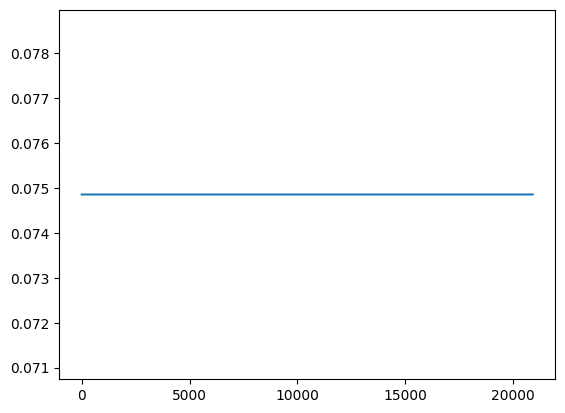

In [ ]:
# prompt: graficar ytrain_pred1

import matplotlib.pyplot as plt

plt.plot(ytrain_pred1)
plt.show()


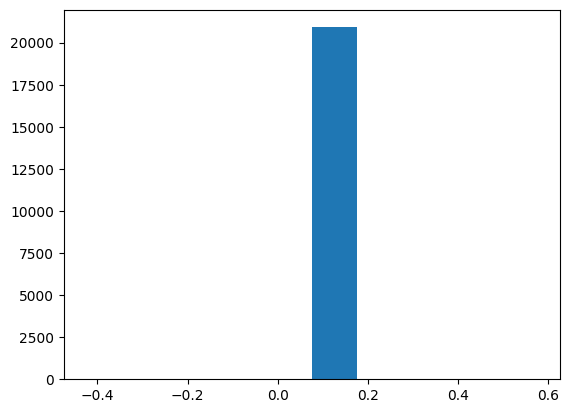

In [ ]:
# prompt: haz un grafico de probabilidad de ytrain_pred

import matplotlib.pyplot as plt
plt.hist(ytrain_pred1)
plt.show()


In [ ]:
#summary_CM(y_train, ytrain_pred1)
#summary_CM(actual, predicted)
#summary_CM(actual, predicted)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_train, ytrain_pred1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(y_val, yval_pred1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(y_test, ytest_pred1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

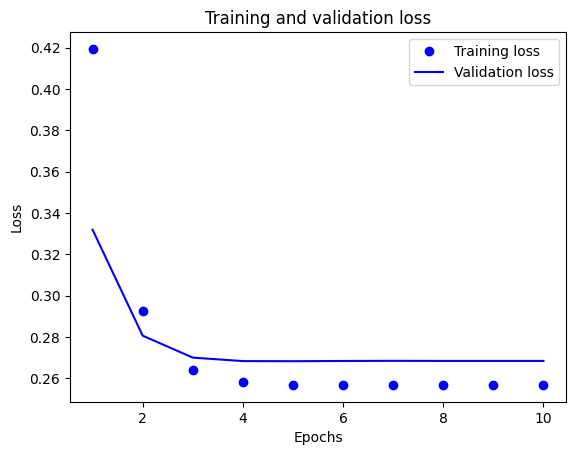

In [ ]:
# prompt: Generame un grafico de la perdida vs epoca del modelo anterior

import matplotlib.pyplot as plt
history = best_model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Get the loss values for training and validation
loss_train = history.history['loss']
loss_val = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(loss_train) + 1)

# Plot the loss values for training and validation
plt.plot(epochs, loss_train, 'bo', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
ytrain_pred2 = best_model2.predict(X_train,verbose=0)
yval_pred2 = best_model2.predict(X_val,verbose=0)
ytest_pred2 = best_model2.predict(X_test,verbose=0)

ytrain_pred2[ytrain_pred2>=0.5]=1
ytrain_pred2[ytrain_pred2<0.5]=0
ytrain_pred2=ytrain_pred2.astype(int)

yval_pred2[yval_pred2>=0.5]=1
yval_pred2[yval_pred2<0.5]=0
yval_pred2=yval_pred2.astype(int)

ytest_pred2[ytest_pred2>=0.5]=1
ytest_pred2[ytest_pred2<0.5]=0
ytest_pred2=ytest_pred2.astype(int)

summary_train_val_test(y_train,ytrain_pred2,y_val,yval_pred2,y_test,ytest_pred2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
Train,0.93,0.0,0.0,0.0
Val,0.92,0.0,0.0,0.0
Test,0.93,0.0,0.0,0.0


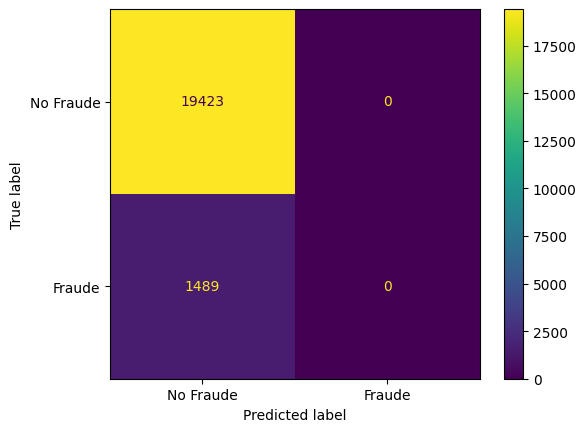

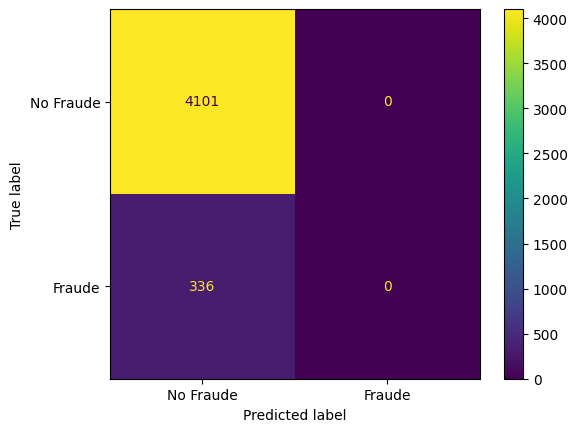

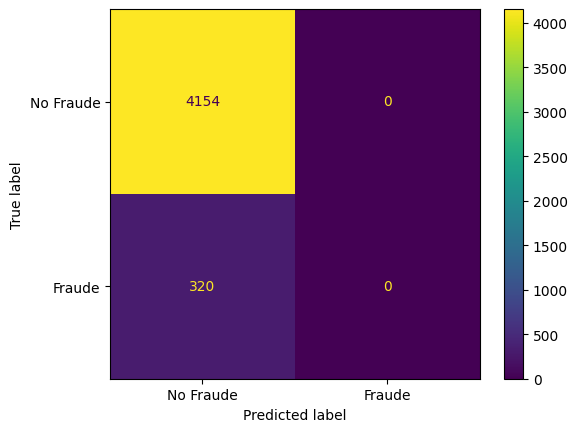

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_train, ytrain_pred2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(y_val, yval_pred2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(y_test, ytest_pred2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

In [ ]:
ytrain_pred3 = best_model3.predict(X_train,verbose=0)
yval_pred3 = best_model3.predict(X_val,verbose=0)
ytest_pred3 = best_model3.predict(X_test,verbose=0)

ytrain_pred3[ytrain_pred3>=0.5]=1
ytrain_pred3[ytrain_pred3<0.5]=0
ytrain_pred3=ytrain_pred3.astype(int)

yval_pred3[yval_pred3>=0.5]=1
yval_pred3[yval_pred3<0.5]=0
yval_pred3=yval_pred3.astype(int)

ytest_pred3[ytest_pred3>=0.5]=1
ytest_pred3[ytest_pred3<0.5]=0
ytest_pred3=ytest_pred3.astype(int)

summary_train_val_test(y_train,ytrain_pred3,y_val,yval_pred3,y_test,ytest_pred3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
Train,0.93,0.0,0.0,0.0
Val,0.92,0.0,0.0,0.0
Test,0.93,0.0,0.0,0.0


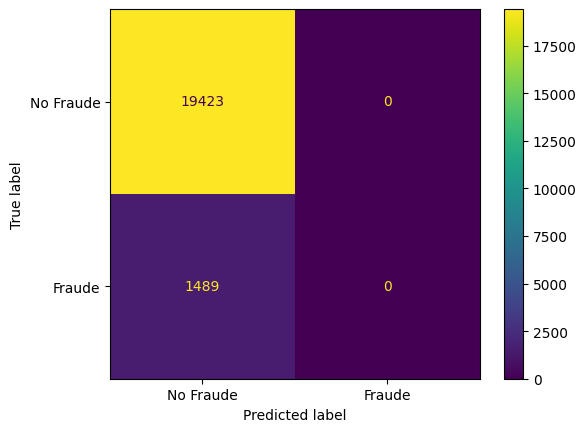

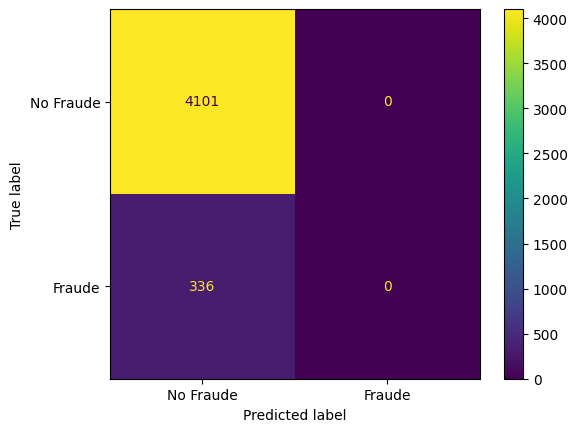

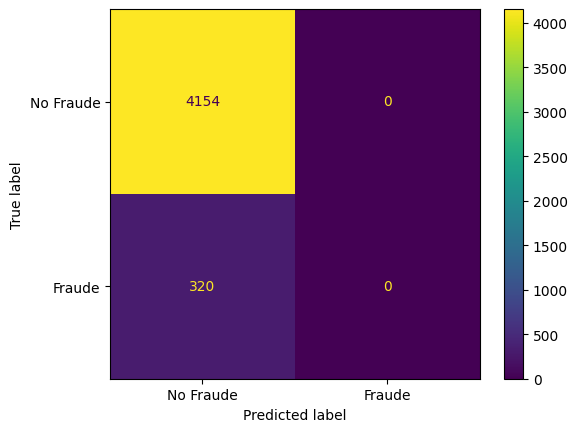

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_train, ytrain_pred3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(y_val, yval_pred3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(y_test, ytest_pred3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

In [ ]:
Xtrain_sub, Xtest_sub, ytrain_sub, ytest_sub = train_test_split(Xsub, ysub, test_size=0.15, random_state=42)
Xtrain_sub, Xval_sub, ytrain_sub, yval_sub = train_test_split(Xtrain_sub, ytrain_sub, test_size=0.175, random_state=42)

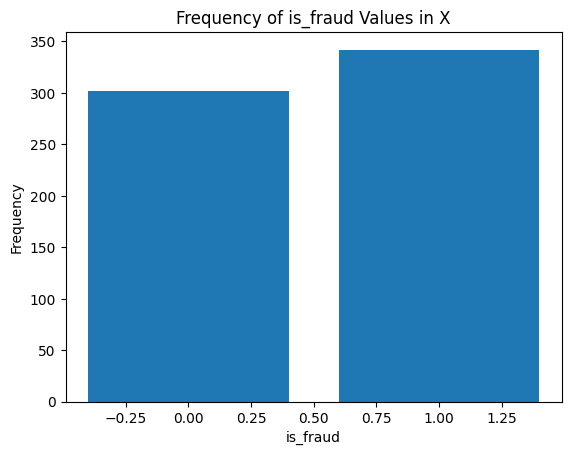

In [ ]:
# prompt: generame un grafico de frecuencia para el datafram x para is:fraud

import matplotlib.pyplot as plt

# Obtener los valores únicos de la columna "is_fraud"
fraud_values = ytest_sub.unique()

# Crear un diccionario para almacenar las frecuencias
fraud_counts = {}

# Contar la frecuencia de cada valor de "is_fraud"
for value in fraud_values:
    fraud_counts[value] = ytest_sub.value_counts()[value]

# Crear el gráfico de frecuencias
plt.bar(fraud_values, fraud_counts.values())
plt.xlabel("is_fraud")
plt.ylabel("Frequency")
plt.title("Frequency of is_fraud Values in X")
plt.show()


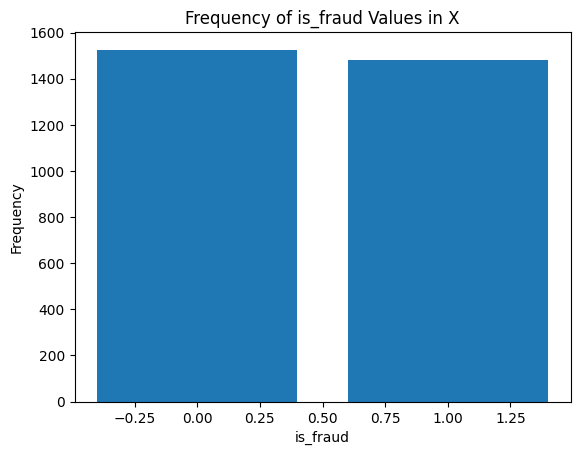

In [ ]:
# prompt: generame un grafico de frecuencia para el datafram x para is:fraud

import matplotlib.pyplot as plt

# Obtener los valores únicos de la columna "is_fraud"
fraud_values = ytrain_sub.unique()

# Crear un diccionario para almacenar las frecuencias
fraud_counts = {}

# Contar la frecuencia de cada valor de "is_fraud"
for value in fraud_values:
    fraud_counts[value] = ytrain_sub.value_counts()[value]

# Crear el gráfico de frecuencias
plt.bar(fraud_values, fraud_counts.values())
plt.xlabel("is_fraud")
plt.ylabel("Frequency")
plt.title("Frequency of is_fraud Values in X")
plt.show()


In [ ]:
ytrain_sub = ytrain_sub.to_numpy()
yval_sub = yval_sub.to_numpy()
ytest_sub = ytest_sub.to_numpy()

In [ ]:
nrowxsub = Xtrain_sub.shape[0]

In [ ]:
tuner.search(Xtrain_sub, ytrain_sub, epochs=30,batch_size=nrowxsub,verbose=0,validation_data=(Xval_sub, yval_sub))

In [ ]:
best_model1sub=tuner.get_best_models(num_models=1)[0]
best_model2sub=tuner.get_best_models(num_models=2)[1]
best_model3sub=tuner.get_best_models(num_models=3)[2]

In [ ]:
best_hps1sub = tuner.get_best_hyperparameters(num_trials = 5)[0].values
best_hps2sub = tuner.get_best_hyperparameters(num_trials = 5)[1].values
best_hps3sub = tuner.get_best_hyperparameters(num_trials = 5)[2].values

In [ ]:
lrt1sub = best_hps1sub['learning_rate']
lrt2sub = best_hps2sub['learning_rate']
lrt3sub = best_hps3sub['learning_rate']

In [ ]:
print(lrt1sub,lrt2sub,lrt3sub)

0.001 0.001 0.001


In [ ]:
best_model1sub.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 170,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_s

In [ ]:
best_model2sub.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 310,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_s

In [ ]:
best_model3sub.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 170,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_s

In [ ]:
best_model1sub.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 110)               1210      
                                                                 
 dropout (Dropout)           (None, 110)               0         
                                                                 
 dense_1 (Dense)             (None, 170)               18870     
                                                                 
 dropout_1 (Dropout)         (None, 170)               0         
                                                                 
 dense_2 (Dense)             (None, 70)                11970     
                                                                 
 dense_3 (Dense)             (None, 1)                 71        
                                                                 
Total params: 32121 (125.47 KB)
Trainable params: 32121 

In [ ]:
best_model2sub.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               1650      
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 190)               28690     
                                                                 
 dropout_1 (Dropout)         (None, 190)               0         
                                                                 
 dense_2 (Dense)             (None, 340)               64940     
                                                                 
 dropout_2 (Dropout)         (None, 340)               0         
                                                                 
 dense_3 (Dense)             (None, 50)                1

In [ ]:
best_model3sub.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 220)               2420      
                                                                 
 dropout (Dropout)           (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 280)               61880     
                                                                 
 dropout_1 (Dropout)         (None, 280)               0         
                                                                 
 dense_2 (Dense)             (None, 240)               67440     
                                                                 
 dense_3 (Dense)             (None, 1)                 241       
                                                                 
Total params: 131981 (515.55 KB)
Trainable params: 13198

In [ ]:
ytrain_pred1sub = best_model1sub.predict(Xtrain_sub,verbose=0)
yval_pred1sub = best_model1sub.predict(Xval_sub,verbose=0)
ytest_pred1sub = best_model1sub.predict(Xtest_sub,verbose=0)

ytrain_pred1sub[ytrain_pred1sub >= 0.5] = 1
ytrain_pred1sub[ytrain_pred1sub < 0.5] = 0
ytrain_pred1sub = ytrain_pred1sub.astype(int)

yval_pred1sub[yval_pred1sub >= 0.5] = 1
yval_pred1sub[yval_pred1sub < 0.5] = 0
yval_pred1sub = yval_pred1sub.astype(int)

ytest_pred1sub[ytest_pred1sub >= 0.5] = 1
ytest_pred1sub[ytest_pred1sub < 0.5] = 0
ytest_pred1sub = ytest_pred1sub.astype(int)

summary_train_val_test(ytrain_sub,ytrain_pred1sub,yval_sub,yval_pred1sub,ytest_sub,ytest_pred1sub)

,Accuracy,Precision,Recall,F1
Train,0.49,0.49,1.0,0.66
Val,0.50,0.50,1.0,0.67
Test,0.53,0.53,1.0,0.69


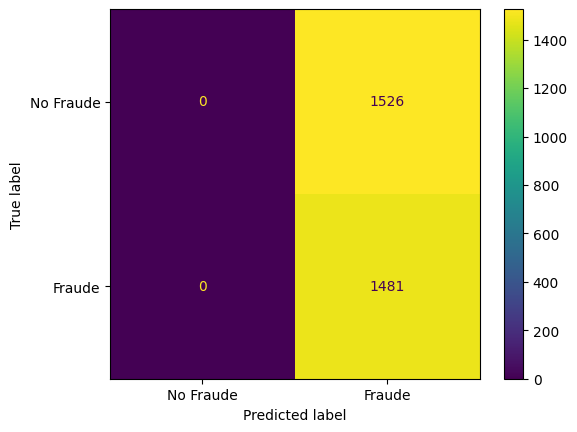

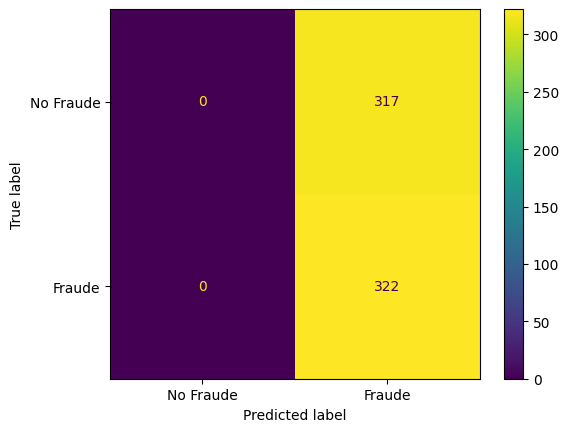

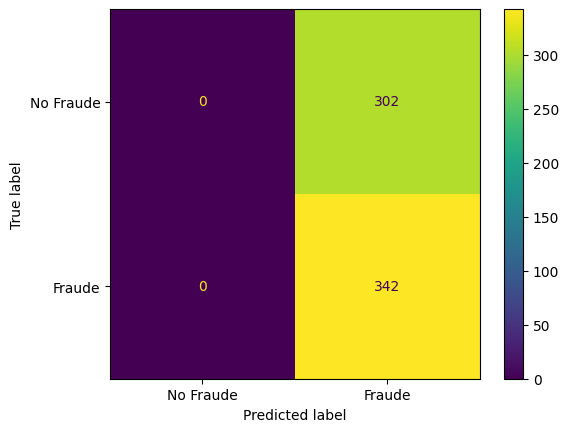

In [ ]:
confusion_matrix = metrics.confusion_matrix(ytrain_sub, ytrain_pred1sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(yval_sub, yval_pred1sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(ytest_sub, ytest_pred1sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

In [ ]:
ytrain_pred2sub = best_model2sub.predict(Xtrain_sub,verbose=0)
yval_pred2sub = best_model2sub.predict(Xval_sub,verbose=0)
ytest_pred2sub = best_model2sub.predict(Xtest_sub,verbose=0)

ytrain_pred2sub[ytrain_pred2sub >= 0.5] = 1
ytrain_pred2sub[ytrain_pred2sub < 0.5] = 0
ytrain_pred2sub = ytrain_pred2sub.astype(int)

yval_pred2sub[yval_pred2sub >= 0.5] = 1
yval_pred2sub[yval_pred2sub < 0.5] = 0
yval_pred2sub = yval_pred2sub.astype(int)

ytest_pred2sub[ytest_pred2sub >= 0.5] = 1
ytest_pred2sub[ytest_pred2sub < 0.5] = 0
ytest_pred2sub = ytest_pred2sub.astype(int)

summary_train_val_test(ytrain_sub,ytrain_pred2sub,yval_sub,yval_pred2sub,ytest_sub,ytest_pred2sub)

,Accuracy,Precision,Recall,F1
Train,0.49,0.49,1.0,0.66
Val,0.50,0.50,1.0,0.67
Test,0.53,0.53,1.0,0.69


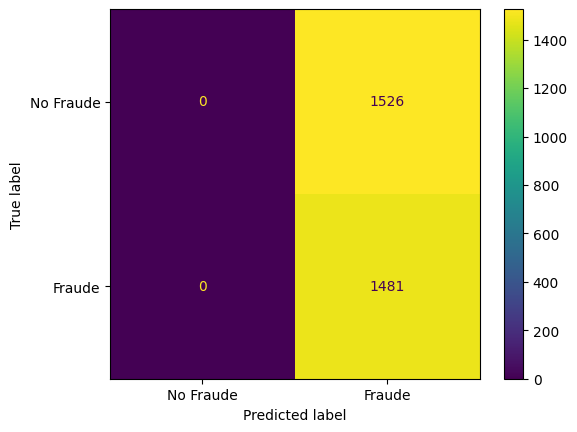

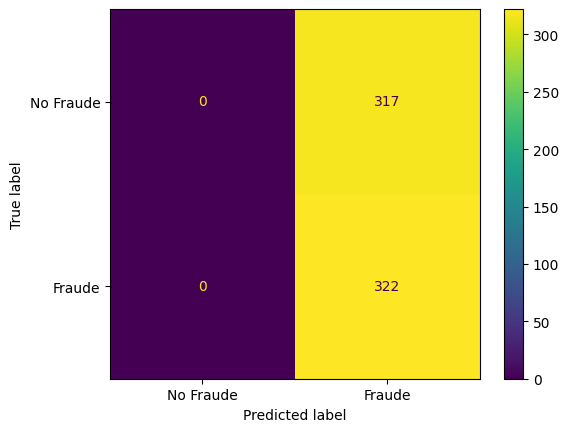

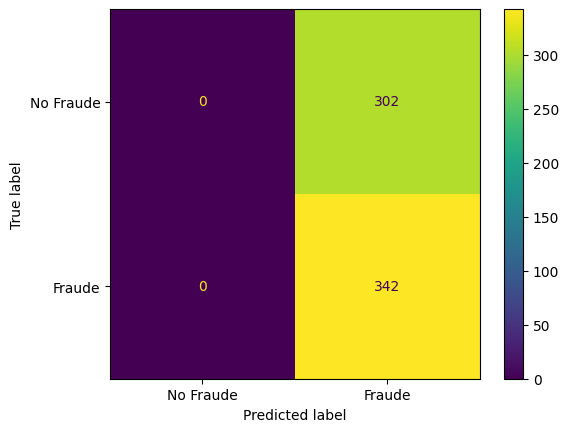

In [ ]:
confusion_matrix = metrics.confusion_matrix(ytrain_sub, ytrain_pred2sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(yval_sub, yval_pred2sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(ytest_sub, ytest_pred2sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

In [ ]:
ytrain_pred3sub = best_model3sub.predict(Xtrain_sub,verbose=0)
yval_pred3sub = best_model3sub.predict(Xval_sub,verbose=0)
ytest_pred3sub = best_model3sub.predict(Xtest_sub,verbose=0)

ytrain_pred3sub[ytrain_pred3sub >= 0.5] = 1
ytrain_pred3sub[ytrain_pred3sub < 0.5] = 0
ytrain_pred3sub = ytrain_pred3sub.astype(int)

yval_pred3sub[yval_pred3sub >= 0.5] = 1
yval_pred3sub[yval_pred3sub < 0.5] = 0
yval_pred3sub = yval_pred3sub.astype(int)

ytest_pred3sub[ytest_pred3sub >= 0.5] = 1
ytest_pred3sub[ytest_pred3sub < 0.5] = 0
ytest_pred3sub = ytest_pred3sub.astype(int)

summary_train_val_test(ytrain_sub,ytrain_pred3sub,yval_sub,yval_pred3sub,ytest_sub,ytest_pred3sub)

,Accuracy,Precision,Recall,F1
Train,0.49,0.49,1.0,0.66
Val,0.50,0.50,1.0,0.67
Test,0.53,0.53,1.0,0.69


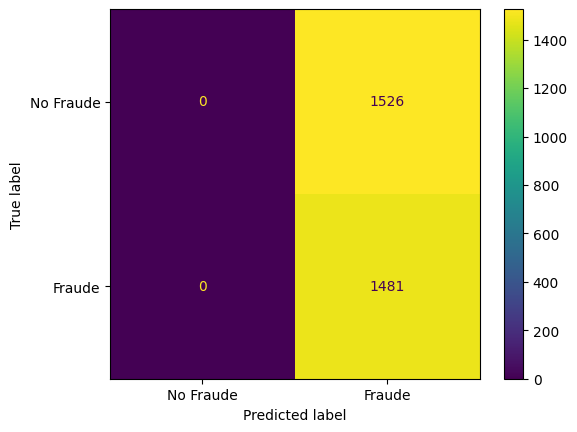

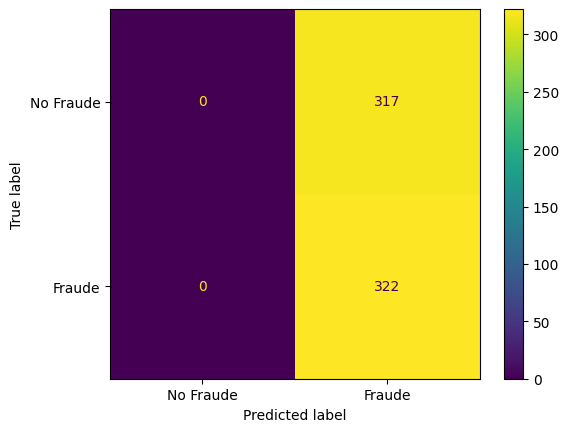

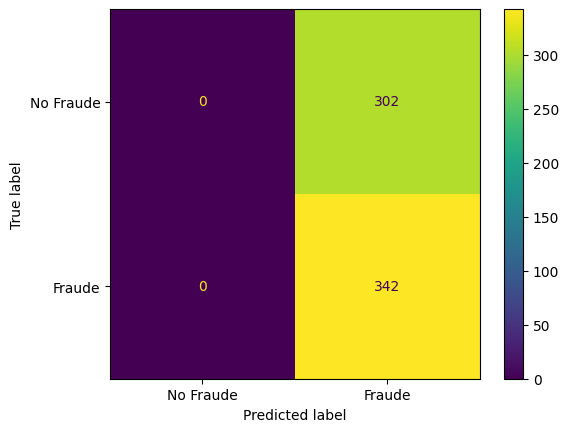

In [ ]:
confusion_matrix = metrics.confusion_matrix(ytrain_sub, ytrain_pred3sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(yval_sub, yval_pred3sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()

confusion_matrix = metrics.confusion_matrix(ytest_sub, ytest_pred3sub)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraude", "Fraude"])
cm_display.plot()
plt.show()